In [30]:
import mne
import os
import re

raw_data = []
raw_dir = os.path.join('..', '..', 'raw')

file_name = 'RestingState' # enter filename, no index
pattern = rf"^sub-[A-Za-z0-9]+_task-{file_name}_eeg\.set$"

for fname in os.listdir(raw_dir):
    if re.match(pattern, fname):
        full_path = os.path.join(raw_dir, fname)
        print(f"Loading: {fname}")
        raw = mne.io.read_raw_eeglab(full_path, preload=True)
        raw_data.append(raw)
        
raw_data 

Loading: sub-NDARAA773LUW_task-RestingState_eeg.set


/var/folders/tr/36xmdf7s2rz9rmtlqnmth4dr0000gn/T/ipykernel_8964/2616478485.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(full_path, preload=True)


Loading: sub-NDARAA396TWZ_task-RestingState_eeg.set
Loading: sub-NDARAB674LNB_task-RestingState_eeg.set


/var/folders/tr/36xmdf7s2rz9rmtlqnmth4dr0000gn/T/ipykernel_8964/2616478485.py:15: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(full_path, preload=True)


[<RawEEGLAB | sub-NDARAA773LUW_task-RestingState_eeg.set, 129 x 178846 (357.7 s), ~176.2 MiB, data loaded>,
 <RawEEGLAB | sub-NDARAA396TWZ_task-RestingState_eeg.set, 129 x 205857 (411.7 s), ~202.7 MiB, data loaded>,
 <RawEEGLAB | sub-NDARAB674LNB_task-RestingState_eeg.set, 129 x 174992 (350.0 s), ~172.4 MiB, data loaded>]

In [31]:
# set time limit based off documentation and assumed estimates

time_limit_min = 0
time_limit_sec = 0

match file_name:
    case "DespicableMe":
        time_limit_min = 2
        time_limit_sec = 51
    case "DiaryOfAWimpyKid":
        time_limit_min = 1
        time_limit_sec = 57
    case "FunwithFractals":
        time_limit_min = 2
        time_limit_sec = 43
    case "RestingState":
        time_limit_min = 3
        time_limit_sec = 0
    case "ThePresent":
        time_limit_min = 3
        time_limit_sec = 23
    case "contrastChangeDetection_run-1":
        time_limit_min = 5
        time_limit_sec = 0
    case "surroundSupp_run-1":
        time_limit_min = 7
        time_limit_sec = 15
    case "symbolSearch":
        time_limit_min = 2
        time_limit_sec = 0


time_limit = time_limit_min * 60 + time_limit_sec 

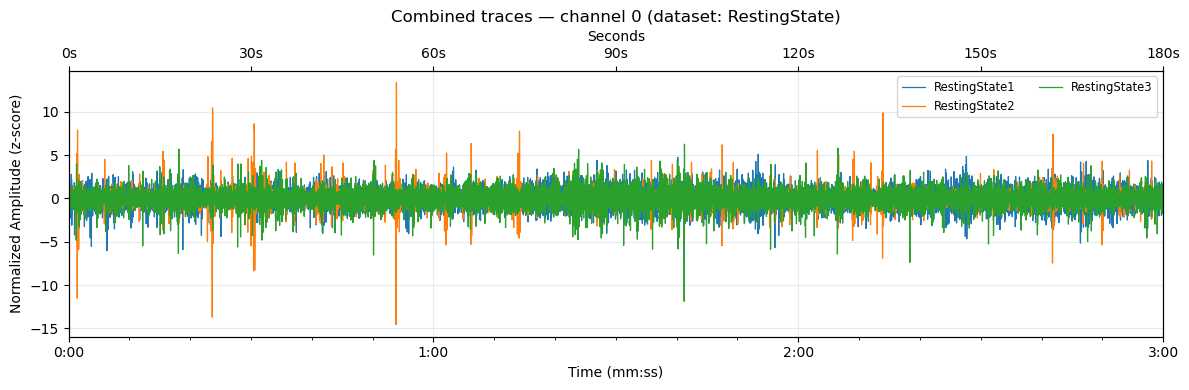

In [32]:
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from biosppy.signals import eeg

# change this to view different channels
chan_name = 0

# format time
def format_mmss(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}:{seconds:02d}"

# set figure
plt.figure(figsize=(12, 4))

# get current axis
ax = plt.gca()

cmap = plt.get_cmap('tab10')
n_recs = len(raw_data)

# loop through each recording
for i, raw in enumerate(raw_data):
    # extract data and sampling rate
    data = raw.get_data(picks=[chan_name])[0]
    sfreq = raw.info['sfreq']

    # trim data to time limit
    data_trim = data[:int(time_limit * sfreq)]
    ts = np.arange(len(data_trim)) / sfreq

    try:
        # apply eeg filtering
        out = eeg.eeg(signal=data_trim, sampling_rate=sfreq, show=False)
        trace = zscore(out['filtered'])
    except Exception:
        trace = zscore(data_trim)

    # plot trace
    color = cmap(i % cmap.N)
    ax.plot(ts, trace, label=f'{file_name}{i+1}', color=color, linewidth=0.9)

# axis formatting
ax.set_xlim(0, time_limit)
ax.set_xlabel('Time (mm:ss)')
ax.set_ylabel('Normalized Amplitude (z-score)')
ax.set_title(f'Combined traces — channel {chan_name} (dataset: {file_name})')
ax.grid(True, alpha=0.25)

# bottom axis formatting: minutes (major) and 10s minor ticks
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))

# top axis formatting: seconds
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax_top.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x)}s"))
ax_top.set_xlabel('Seconds')

ax.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

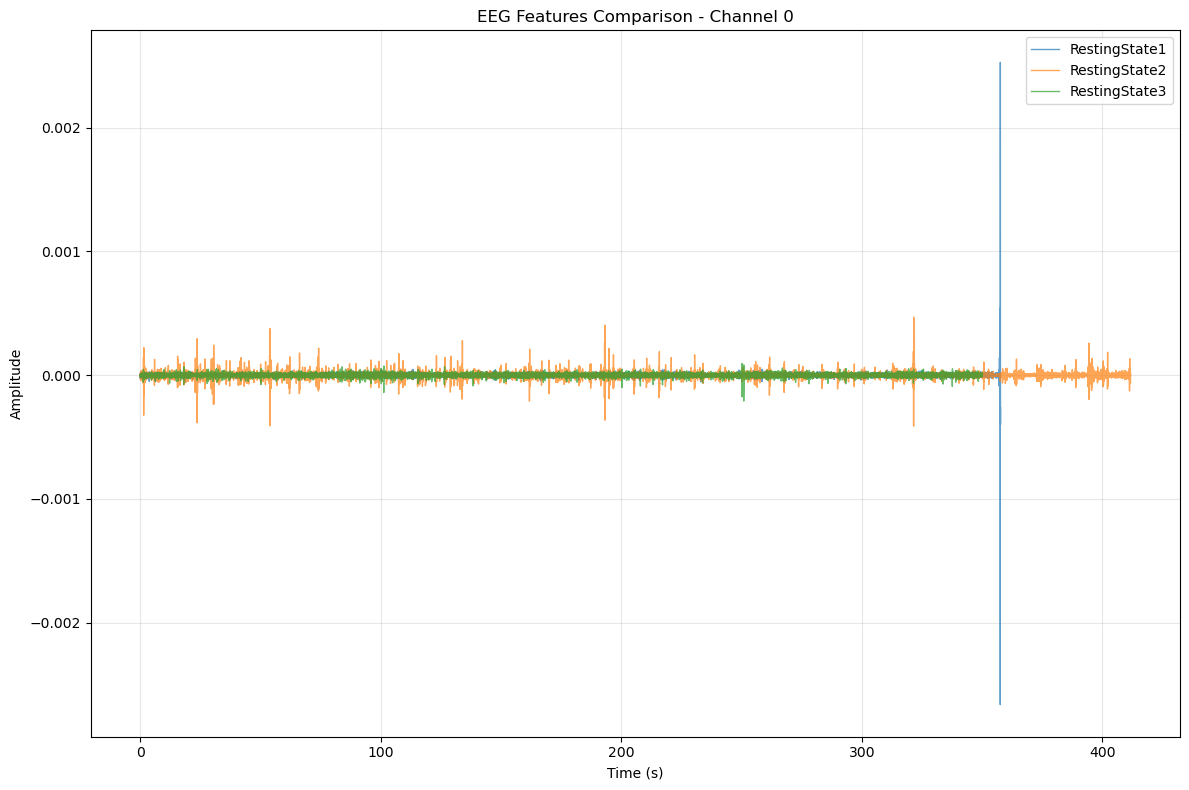

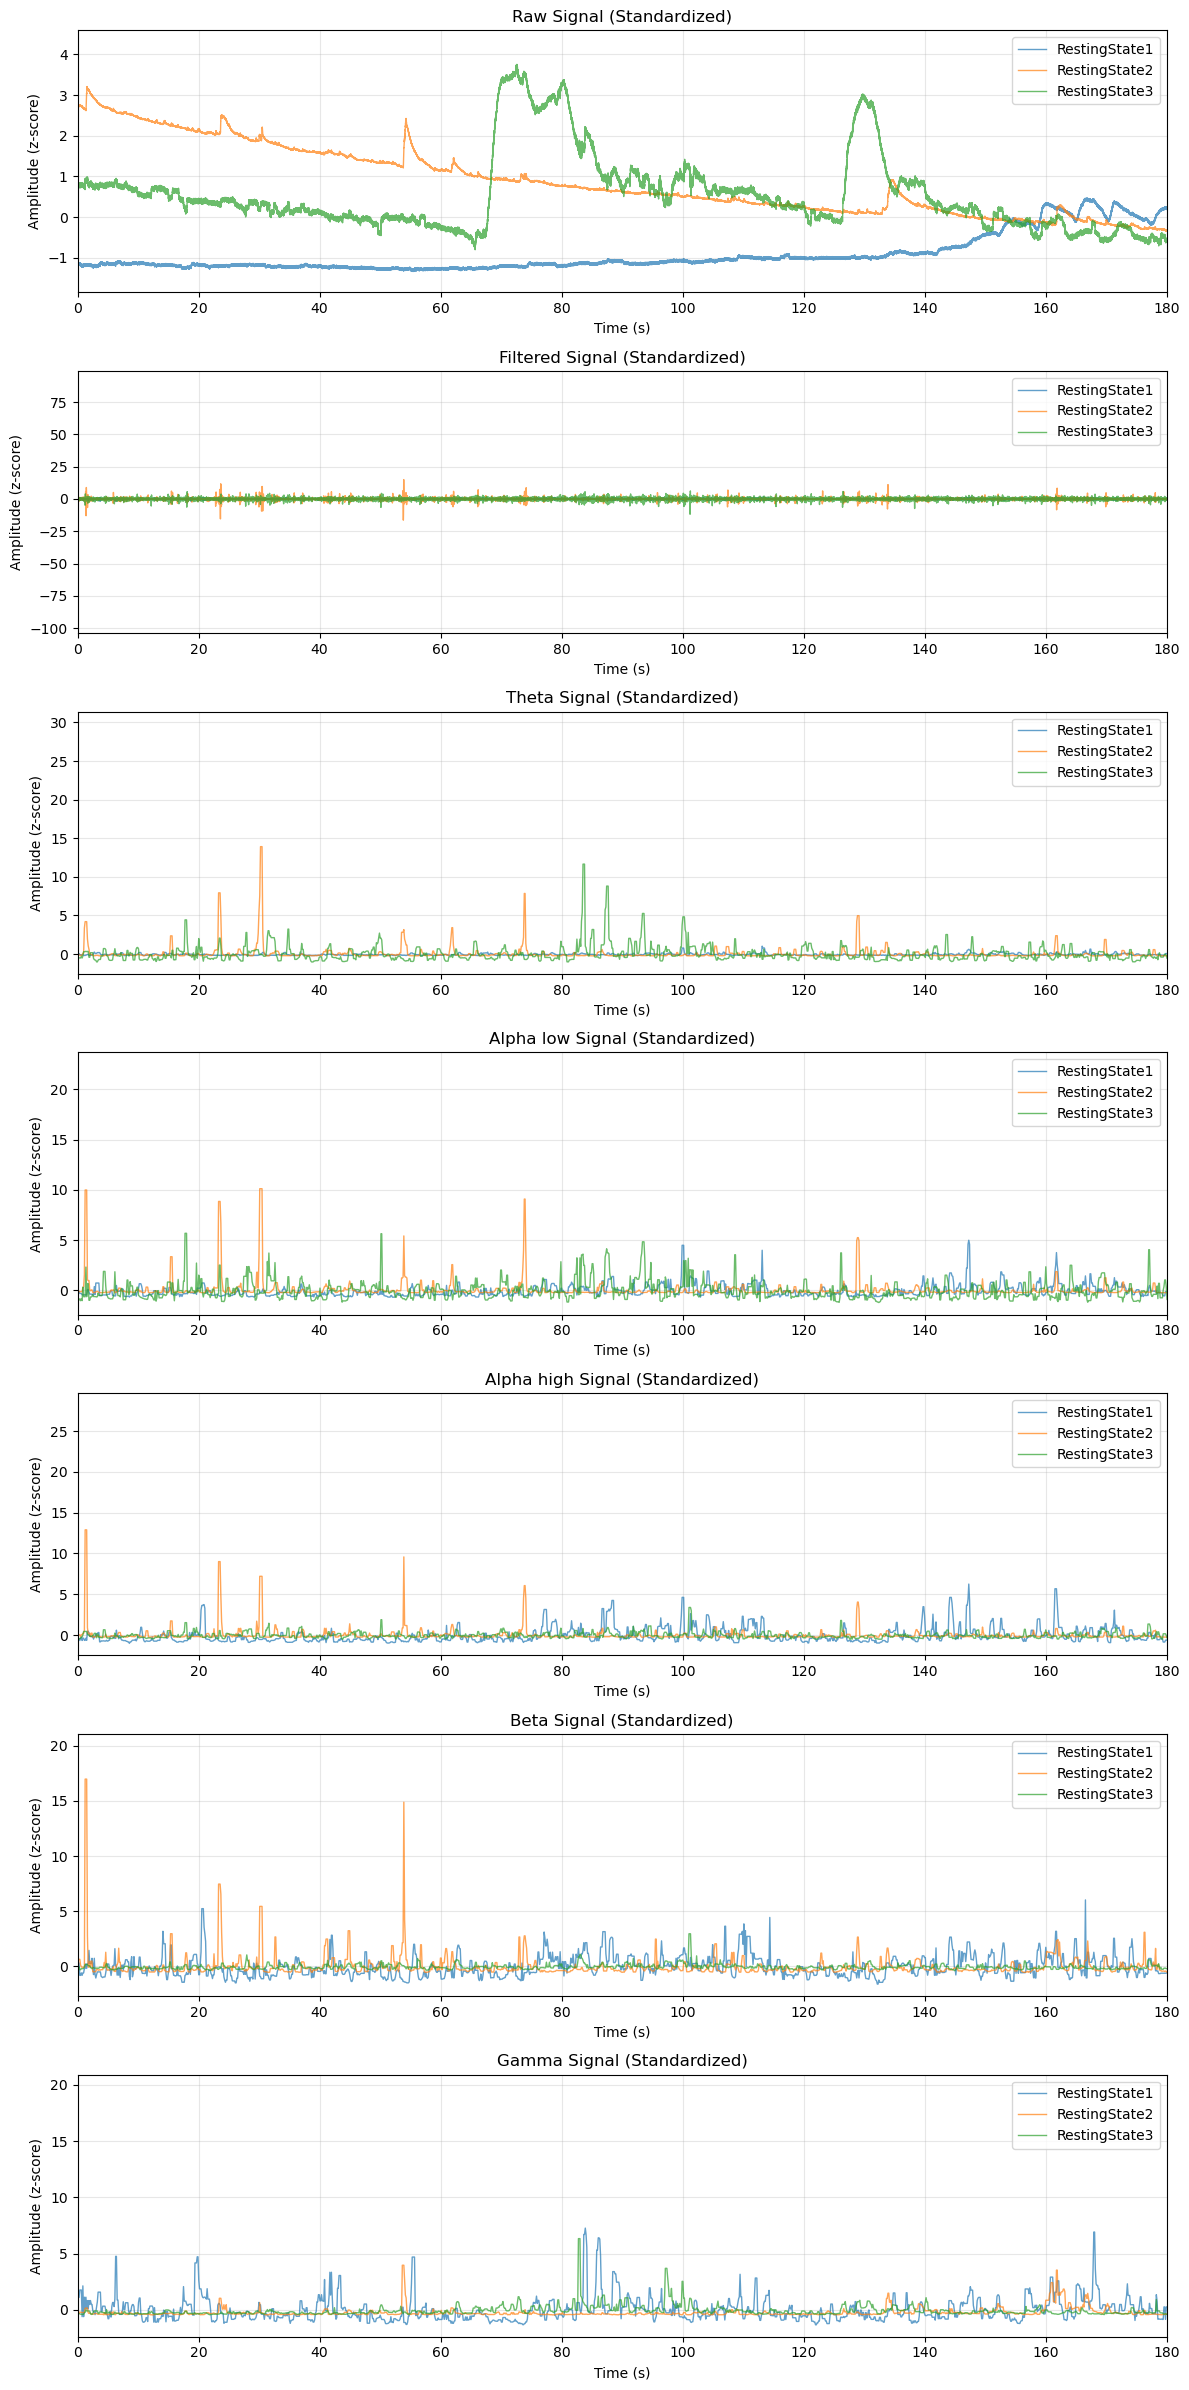

In [33]:
# plot filtered EEG features for comparison (more than just filtered signal)

# create plot
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('tab10')

# loop through each recording
for i, raw in enumerate(raw_data):
    # extract data and compute features
    data = raw.get_data(picks=[chan_name])[0]
    features = eeg.eeg(signal=data, sampling_rate=raw.info['sfreq'], show=False)
    
    # plot filtered signal
    color = cmap(i % cmap.N)
    plt.plot(features['ts'], features['filtered'], 
             label=f'{file_name}{i+1}', 
             color=color, 
             alpha=0.7,
             linewidth=1)

# axis formatting
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'EEG Features Comparison - Channel {chan_name}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# plot multiple EEG features in subplots for comparison
fig, axs = plt.subplots(7, 1, figsize=(12, 24)) 
cmap = plt.get_cmap('tab10')

# feature names
feature_names = ['raw', 'filtered', 'theta', 'alpha_low', 'alpha_high', 'beta', 'gamma']

# loop through each recording
for i, raw in enumerate(raw_data):
    data = raw.get_data(picks=[chan_name])[0]
    features = eeg.eeg(signal=data, sampling_rate=raw.info['sfreq'], show=False)
    
    color = cmap(i % cmap.N)
    
    # Plot each feature type
    for idx, feature in enumerate(feature_names):
        if feature == 'raw':
            # plot raw signal
            normalized_signal = zscore(data)
            ts = np.arange(len(data)) / raw.info['sfreq']
            axs[idx].plot(ts, normalized_signal, 
                         label=f'{file_name}{i+1}',
                         color=color,
                         alpha=0.7,
                         linewidth=1)
        elif feature == 'filtered':
            # plot filtered signal
            normalized_signal = zscore(features['filtered'])
            axs[idx].plot(features['ts'], normalized_signal, 
                         label=f'{file_name}{i+1}',
                         color=color,
                         alpha=0.7,
                         linewidth=1)
        else:
            # plot frequency bands
            normalized_signal = zscore(features[feature])
            axs[idx].plot(features['features_ts'], normalized_signal, 
                         label=f'{file_name}{i+1}',
                         color=color,
                         alpha=0.7,
                         linewidth=1)
        
        axs[idx].set_title(f'{feature.replace("_", " ").capitalize()} Signal (Standardized)')
        axs[idx].set_xlabel('Time (s)')
        axs[idx].set_ylabel('Amplitude (z-score)')
        axs[idx].grid(True, alpha=0.3)
        axs[idx].legend(loc='upper right')
        axs[idx].set_xlim(0, time_limit)
plt.tight_layout()
plt.show()